In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from datetime import timedelta 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 0: Import and Preliminary Exploration

In [2]:
#Load the imputed df 
df = pd.read_csv('data/df1_mp_imputed2.csv')

In [3]:
pd.set_option('display.max_columns',500)

In [4]:
# Look at a sample
df.sample(3).sort_index().T

,272,3589,5882
CRASH_ID,20150212ER-15-11271,20160212ER-16-10810,2.02E+17
CTY_NAME,BERGEN,BERGEN,PASSAIC
MUN_NAME,EAST RUTHERFORD BORO,EAST RUTHERFORD BORO,CLIFTON CITY
DATE,11/29/2015,12/21/2016,3/28/2017
DAY,S,W,TU
TIME,1721.0,1734.00,749.00
POL_CODE,1,1,1
POL_DEPT,EAST RUTHERFORD PD,EAST RUTHERFORD PD,CLIFTON PD
POL_STA,ERPD,NaN,NaN
KILLED,0,0,0


In [5]:
# Total No. of crash
print('Total number of accident between 2013 and 2018:', df.shape[0])


Total number of accident between 2013 and 2018: 8115


In [6]:
# No. of features in df
print('Number of features in df:', df.shape[1])

Number of features in df: 49


## 1: Filter Irrelevant Features

In [7]:
# Remove irrelevant features
irrevant_cols = ['CTY_NAME', 'MUN_NAME', 'POL_CODE', 'POL_DEPT','POL_STA', 'INTERSEC', 'RT_SFX','SRI', 'X_DIST', 
                 'X_DIR', 'X_NAME', 'IS_RAMP', 'RAMP_RT', 'RAMP_DIR', 'SPD_X', 'LAT', 'LONG', 'PROP_DMG', 'BADGE', 
                 'SPD_LMT', 'DIST_UNT', 'RD_CHAR']
                 
df.drop(columns = irrevant_cols, inplace = True)

### Remove Wrong Records

It was found that the dataset includes crash records occurred on other roadways. These wrong records were removed.

In [8]:
df['LOCATION'].value_counts()

NJ 3                                                  7879
MONMOUTH COUNTY 3                                      234
OCEAN COUNTY 3                                           2
Name: LOCATION, dtype: int64

In [9]:
# Text has an extra blank space on right side
df['LOCATION'] = df['LOCATION'].str.rstrip()
df.drop(df[(df['LOCATION'] == 'MONMOUTH COUNTY 3') | (df['LOCATION'] == 'OCEAN COUNTY 3')].index, inplace = True)

The number of crash occurred on NJ 3 was 7,879 for the period between Jan, 2013 and Dec, 2018

### Filter 'TIME' with insufficient information

Note that digits 3 and 4 are insufficient information. These will be removed later

In [10]:
df['TIME'].astype(str).str.len().value_counts()

6    5369
5    2343
4     112
3      55
Name: TIME, dtype: int64

In [11]:
# Number of insufficient time information
df[df['TIME'].astype(str).str.len() <= 4].shape

(167, 27)

### Find the number of NA in 'MP' 

In [12]:
df['MP'].isna().sum(axis=0)

1819

In [13]:
# Number of missing MP
df[df['MP'].isna()].shape

(1819, 27)

### Review crash frequency

In [14]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [15]:
df[df['MP'].isna()].groupby(df['DATE'].dt.year)['TIME'].count()

DATE
2013    338
2014    390
2015    373
2016    423
2017    228
2018     63
Name: TIME, dtype: int64

In [16]:
df[(df['TIME'].astype(str).str.len() > 4) & (df['MP'].isna() == False)].groupby(df['DATE'].dt.year)['TIME'].count()

DATE
2013     917
2014     779
2015     727
2016     859
2017    1206
2018    1440
Name: TIME, dtype: int64

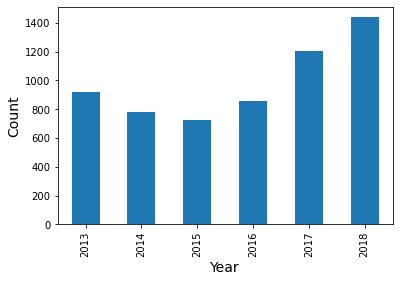

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = df[(df['TIME'].astype(str).str.len() > 4) & (df['MP'].isna() == False)].groupby(df['DATE'].dt.year)['TIME'].count().plot.bar()
#fig.suptitle('No. of crash by year', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

#### Crash distribution per severity

Text(0, 0.5, 'Count')

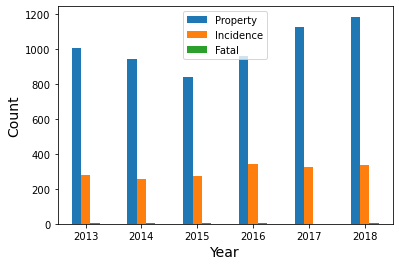

In [18]:

P = df[df['SEVERITY']=='P'].groupby(df['DATE'].dt.year)['SEVERITY'].count()
I = df[df['SEVERITY']=='I'].groupby(df['DATE'].dt.year)['SEVERITY'].count()
F = df[df['SEVERITY']=='F'].groupby(df['DATE'].dt.year)['SEVERITY'].count()

index = [2013, 2014, 2015, 2016, 2017, 2018]

df1 = pd.DataFrame({'Property':P, 'Incidence':I, 'Fatal':F}, index = index)
ax = df1.plot.bar(rot=0)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)

Convert 'TIME' data type to integer. First, fix `Nan` and write a function to convert integer into a `hh:mm` format

In [19]:
df['TIME'].fillna(0, inplace = True)
df['TIME'] = df['TIME'].astype(int)

In [20]:
df['TIME'].astype(str).str.len().value_counts()

4    5369
3    2343
2     112
1      55
Name: TIME, dtype: int64

In [21]:
df.drop(df[df['TIME'].astype(str).str.len() == 1].index, inplace = True)
df.drop(df[df['TIME'].astype(str).str.len() == 2].index, inplace = True)

In [22]:
#Input: Military time (int)
#Output: The hour from military time (int)
#Desc: Extracts the hour from military time 
def time_conversion(time):
    #turn the time into a string so we can subset it
    time = str(time)
    #if the military time only has two elements, that means that the time is 00:xx or 00:0x
    if len(time)<=2:
        return(0)
    #if the length of the time is 3, then it will be 0y:xx in military time
    elif len(time)==3:
        return(time[0]+':'+time[1:3]+':'+'00')
    else:
        return(time[:2]+':'+time[2:4]+':'+'00')

In [23]:
df['TIME'] = [time_conversion(i) for i in df['TIME']]

In [24]:
from datetime import timedelta 
df['timestamp'] = pd.to_datetime(df['DATE'].apply(str) + ' ' + df['TIME'].apply(str))

## 2: Save the Processed Data

In [25]:
df.drop(df[df['MP'].isnull() == True].index, inplace = True)
df.drop(df[df['TMC'].isnull() == True].index, inplace = True)

In [26]:
print('Total number of rows and columns: {} and {}'.format(df.shape[0], df.shape[1]))

Total number of rows and columns: 5915 and 28


In [27]:
df.to_csv('./data/Filtered_crash_records.csv')